In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
from copy import deepcopy

In [38]:
dataframe = pd.read_csv('C:/Users/anne.borges/OneDrive - FORTBRASIL ADM CARTOES DE CRED SA/Documentos/infinity_ds_project/data/walmart.csv')
df = dataframe
df_ml = df

* Não foi necessário tratar os dados para a Análise Exploratória

Percentuais e Cálculos

In [39]:
qtd_clientes_unicos = df['User_ID'].nunique()
qtd_produtos = df['Product_ID'].nunique()
qtd_ocupacoes = df['Occupation'].nunique()
qtd_cidades = df['City_Category'].nunique()
qtd_publico_feminino =  df[df['Gender'] == 'F']['User_ID'].nunique()
qtd_publico_masculino =  df[df['Gender'] == 'M']['User_ID'].nunique()
qtd_total_compras = df['Purchase'].count()
qtd_compras_por_cidade = df.groupby('City_Category')['Purchase'].sum()
qtd_compras_por_categoria = df.groupby('Product_Category')['Purchase'].count()
qtd_compras_por_product_id = df.groupby('Product_ID')['Purchase'].count()

qtd_compras_por_categoria_genero = df.groupby(['Product_Category', 'Gender'])['Purchase'].count().unstack()
qtd_compras_por_estado_civil = df.groupby('Marital_Status')['Purchase'].sum()

qtd_usuarios_por_cidade = df.groupby('City_Category')['User_ID'].nunique().reset_index()
qtd_usuarios_por_cidade = df.groupby('Product_ID')['User_ID'].nunique().reset_index()


In [40]:
mediana_compras = df['Purchase'].median()
mediana_compras_por_faixa_etaria = df.groupby('Age')['Purchase'].median()

In [41]:
percentual_publico_feminino = (qtd_publico_feminino / qtd_clientes_unicos) * 100
percentual_publico_masculino = (qtd_publico_masculino / qtd_clientes_unicos) * 100

In [ ]:
percentual_compras_por_cidade = (qtd_compras_por_cidade / qtd_compras_por_cidade.sum()) * 100
percentual_compras_por_cidade

In [ ]:
percentual_compras_por_estado_civil = (qtd_compras_por_estado_civil / qtd_compras_por_estado_civil.sum()) * 100
percentual_compras_por_estado_civil

In [ ]:
percentual_compras_categoria_produto = (qtd_compras_por_categoria / qtd_compras_por_categoria.sum()) * 100
percentual_compras_categoria_produto

In [ ]:
percentual_compras_por_product_id = (qtd_compras_por_product_id / qtd_compras_por_product_id.sum()) * 100
percentual_compras_por_product_id_top_10 = percentual_compras_por_product_id.nlargest(10)
percentual_compras_por_product_id_top_10

In [46]:
media_compras_por_genero = df.groupby('Gender')['Purchase'].mean()
percentual_compras_genero = (df.groupby('Gender')['Purchase'].count() / qtd_total_compras) * 100
percentual_compras_categoria_genero = qtd_compras_por_categoria_genero.div(qtd_compras_por_categoria_genero.sum(axis=1), axis=0) * 100


In [47]:
Q1 = df['Purchase'].quantile(0.25)
Q3 = df['Purchase'].quantile(0.75)
IQR = Q3 - Q1

limite_superior = Q3 + 1.5 * IQR
limite_inferior = Q1 - 1.5 * IQR

outliers = df[(df['Purchase'] > limite_superior) | (df['Purchase'] < limite_inferior)]

Aplicando Machine Learning - Pipeline e Encoding

In [48]:
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)
label_encoder = LabelEncoder()

In [ ]:
df_ml.info()

In [ ]:
print(df_ml.isnull().sum())

Tratamento dos Dados para os Modelos de Machine Learning

In [51]:
df_ml = df_ml.drop(columns=['User_ID', 'Product_ID'], axis=1)

In [52]:
df_ml['Stay_In_Current_City_Years'] = df_ml['Stay_In_Current_City_Years'].str.replace('+', '').astype(int)

In [53]:
df['Marital_Status'] = df['Marital_Status'].astype(str)
df_ml['Gender'] = df_ml['Gender'].astype(str)
df_ml['City_Category'] = df_ml['City_Category'].astype(str)
df_ml['Occupation'] = df_ml['Occupation'].astype(str)
df_ml['Product_Category'] = df_ml['Product_Category'].astype(str)

In [54]:
faixa_etaria = {
    '0-17': 0,
    '18-25': 1,
    '26-35': 2,
    '36-45': 3,
    '46-50': 4,
    '51-55': 5,
    '55+': 6
}

df_ml['Age'] = df_ml['Age'].map(faixa_etaria)

In [55]:
#ordinal_columns = ['Age', 'Stay_In_Current_City_Years'] - Já tratado manualmente
categoricos_encoder = ['Gender', 'City_Category', 'Occupation', 'Product_Category']


In [ ]:
df_ml['Purchase'].describe()

In [72]:
Q1 = df_ml['Purchase'].quantile(0.25)
Q3 = df_ml['Purchase'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_ml = df_ml[(df_ml['Purchase'] >= limite_inferior) & (df_ml['Purchase'] <= limite_superior)]

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_ml['Purchase'], bins=30, kde=True)
plt.title('Distribuição dos Valores de Purchase (Sem Outliers)')
plt.show()

In [ ]:
df_final_ml = df_ml.copy()
for itens in categoricos_encoder:
    df_final_ml[itens] = label_encoder.fit_transform(df_ml[itens])

df_final_ml.head()


In [ ]:
df_final_ml.info()

In [ ]:
df_final_ml.describe()

In [83]:
# Features (X) e alvo para Classificação (y1), Regressão (y2)
X = df_final_ml.drop(['Purchase'], axis=1) # Features
y = df_final_ml['Purchase'] # Labels

Normalização dos Dados (Labels)

In [ ]:
y = pd.DataFrame(y)
scaler = RobustScaler().fit(y)
y = scaler.fit_transform(y)
y = pd.DataFrame(y, columns=['Purchase'])
y

Divisão dos dados em treino e teste

X: Dados de treino (75%) com as features para a classificação.
y: Dados de teste (25%) com as features para a classificação.


In [118]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_treino, y_treino)
y_pred = model.predict(X_teste)
acuracia = model.score(X_teste, y_teste)
print(f'Acurácia Regressão Linear: {acuracia}') #R2

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_teste, y_pred, color='blue', edgecolor='k')
plt.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], color='red', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Previstos')
plt.show()

In [ ]:
model = SGDClassifier(max_iter=1000)

batch_size = 1000
for i in range(0, len(X_treino), batch_size):
    end_i = min(i + batch_size, len(X_treino))
    model.partial_fit(X_treino[i:end_i], y_treino[i:end_i], classes=np.unique(y_treino))

y_pred = model.predict(X_teste)

acuracia = accuracy_score(y_teste, y_pred)
print(f'Acurácia: {acuracia}')

print(classification_report(y_teste, y_pred))

In [ ]:
model = LogisticRegression(max_iter=5, C=0.1)
model.fit(X_treino, y_treino)

In [125]:

model = DecisionTreeRegressor()
model.fit(X_treino, y_treino)

y_pred_dt = model.predict(X_teste)

acuracia_dt = model.score(X_teste, y_teste)
print(f'Acurácia (Árvore de Decisão): {acuracia_dt}')


Acurácia (Árvore de Decisão): 0.6412866288698971


In [128]:
model = Ridge(alpha=1.0)  # Você pode ajustar alpha conforme necessário
model.fit(X_treino, y_treino)

y_pred_ridge = model.predict(X_teste)
acuracia_ridge = model.score(X_teste, y_teste)
print(f'Acurácia da Regressão Ridge: {acuracia_ridge}')

Acurácia da Regressão Ridge: 0.18216057547126896


In [127]:
model = RandomForestRegressor(n_estimators=10)
model.fit(X_treino, y_treino)

acuracia = model.score(X_teste, y_teste)
print(f'Acurácia Random Forest: {acuracia}')

c:\Users\anne.borges\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Acurácia Random Forest: 0.6464580745819661


In [130]:
model = Lasso()
model.fit(X_treino, y_treino)

y_pred_lasso = model.predict(X_teste)

acuracia_lasso = model.score(X_teste, y_teste)
print(f'Acurácia Regressão Lasso: {acuracia_lasso}')

Acurácia Regressão Lasso: 0.1489211767119788


In [132]:

model = GradientBoostingRegressor()

model.fit(X_treino, y_treino)

y_pred_gb = model.predict(X_teste)

acuracia_gb = model.score(X_teste, y_teste)
print(f'Acurácia Gradient Boosting: {acuracia_gb}')


c:\Users\anne.borges\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Acurácia Gradient Boosting: 0.6282319128107754


Análise Exploratória - Gráficos

Matriz de Correlação

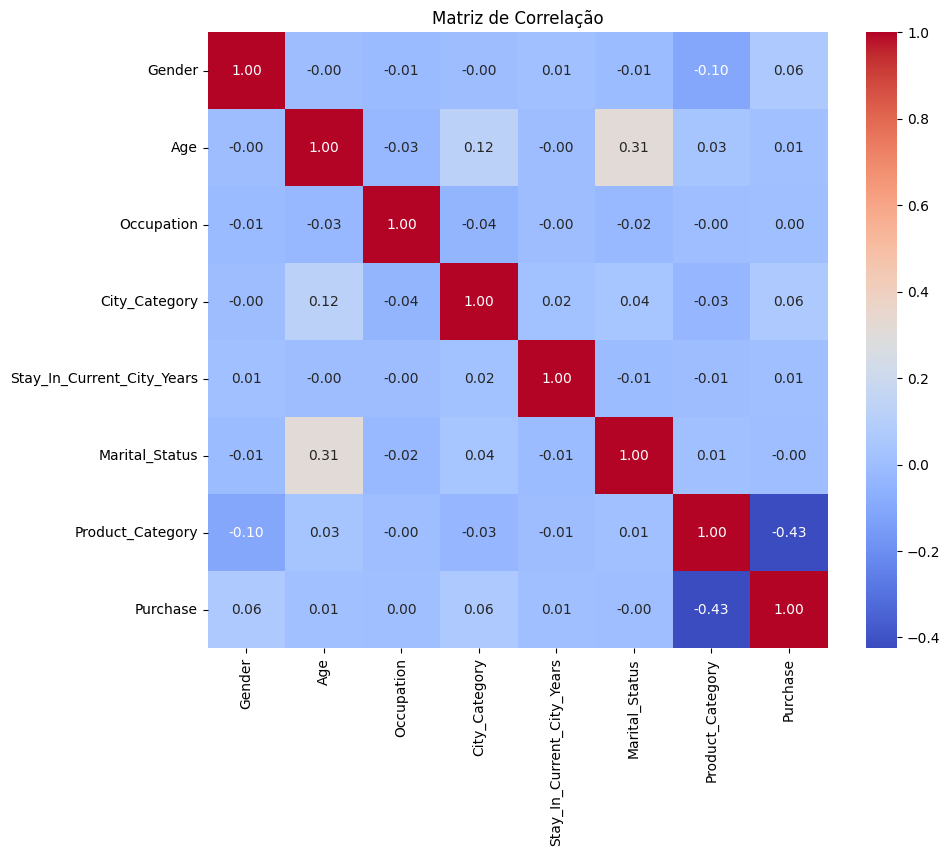

In [137]:
correlacao_matrix = df_final_ml.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacao_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlação")
plt.show()

???????
1. A correlação entre Purchase e Product_Category é negativa (-0.43), ou seja, conforme o valor da categoria do produto aumenta, o valor de compra tende a diminuir.
2. O Gênero (Gender) tem uma correlação positiva com Purchase (0.06), mas o valor é baixo, indicando uma relação fraca.
3. A maior correlação observada é entre Marital_Status e Age (0.31), sugerindo que a idade pode influenciar o estado civil.

Distribuição dos Clientes

In [ ]:
num_categorias = len(df['Marital_Status'])
cores_aleatorias = np.random.rand(num_categorias, 3)

plt.figure(figsize=(12, 8))

plt.bar(percentual_compras_por_estado_civil.index, 
        percentual_compras_por_estado_civil.values, 
        color=cores_aleatorias,
        edgecolor='black')

plt.title('Percentual de Compras por Estado Civil', fontsize=16)
plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Percentual(%)', fontsize=12)

for i in range(len(percentual_compras_por_estado_civil)):
    plt.text(i, percentual_compras_por_estado_civil.values[i] + 1,
             f'{percentual_compras_por_estado_civil.values[i]:.1f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
num_categorias = len(df['City_Category'])
cores_aleatorias = np.random.rand(num_categorias, 3)

plt.figure(figsize=(12, 8))

plt.bar(percentual_compras_por_cidade.index, 
        percentual_compras_por_cidade.values, 
        color=cores_aleatorias, 
        edgecolor='black')

plt.title('Percentual de Compras por Cidade', fontsize=16)
plt.xlabel('Cidade', fontsize=12)
plt.ylabel('Percentual(%)', fontsize=12)

for i in range(len(percentual_compras_por_cidade)):
    plt.text(i, percentual_compras_por_cidade.values[i] + 1,
             f'{percentual_compras_por_cidade.values[i]:.1f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
categorias = ['Feminino', 'Masculino']
percentuais = [percentual_publico_feminino, percentual_publico_masculino]

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(categorias, percentuais, color=['lavender', 'lightgreen'])

plt.xlabel('Gênero')
plt.ylabel('Percentual(%)')
plt.title('Visão Geral do Público (Por Gênero)')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Média de compras por faixa etária.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mediana_compras_por_faixa_etaria.index, mediana_compras_por_faixa_etaria.values, marker='o', linestyle='-', color='b')

for i, value in enumerate(mediana_compras_por_faixa_etaria):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

plt.xlabel('Faixa Etária')
plt.ylabel('Mediana de Compras')
plt.title('Mediana de Compras por Faixa Etária')

plt.show()


Média de compras por gênero.

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))

percentual_compras_genero.plot(kind='bar', color=['lavender', 'lightgreen'], ax=ax)

plt.xlabel('Faixa Etária')
plt.ylabel('Percentual(%)')
plt.title('Percentual de Compras por Gênero')

for i, value in enumerate(percentual_compras_genero):
    perc = percentual_compras_genero.iloc[i]
    ax.text(i, value + 1, f'{perc:.2f}%', ha='center', va='bottom', color='black')

plt.show()


Distribuição de Vendas por Categoria de Produto

In [ ]:
percentual_compras_categoria_produto.plot(kind='bar', color='skyblue', figsize=(10, 6))
percentual_compras_categoria_produto = percentual_compras_categoria_produto.sort_values(ascending=False)


plt.xlabel('Produto')
plt.ylabel('Percentual(%)')
plt.title('Percentual de Vendas por Categoria de Produto')

for i, value in enumerate(percentual_compras_categoria_produto):
    perc = percentual_compras_categoria_produto.iloc[i]
    ax.text(i, value + 1, f'{perc:.2f}%', ha='center', va='bottom', color='black')

plt.show()

In [ ]:

percentual_compras_por_product_id_top_10.plot(kind='bar', color='skyblue', figsize=(10, 6))
percentual_compras_por_product_id_top_10 = percentual_compras_por_product_id_top_10.sort_values(ascending=False)


plt.xlabel('Product Id')
plt.ylabel('Percentual(%)')
plt.title('Percentual Product Id Mais Vendidos (Top 10)')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

percentual_compras_categoria_genero.plot(kind='bar', ax=ax, color=['#ff9999', '#66b3ff'])

ax.set_title('Percentual de Vendas por Produto e Gênero', fontsize=16)
ax.set_xlabel('Produto', fontsize=12)
ax.set_ylabel('Percentual de Vendas (%)', fontsize=12)

ax.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [ ]:
df.boxplot("Purchase", by = "Gender")
df.boxplot("Purchase", by = "Occupation")
df.boxplot("Purchase", by = "Marital_Status")
df.boxplot("Purchase", by = "Product_Category")
df.boxplot("Purchase", by = "City_Category")
df.boxplot("Purchase", by = "Stay_In_Current_City_Years")
